In [1]:
from library_dicom.dicom_processor.model.reader.Instance_RTSS import Instance_RTSS

from library_dicom.rtss_processor.model.MaskBuilder_RTSS import MaskBuilder_RTSS
from library_dicom.dicom_processor.model.Series import Series

import matplotlib.pyplot as plt
import numpy as np

## RTSTRUCT file -> Mask 

In [2]:
rtss_path = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/RT_STRUCT/201802409 BARAT GALPIN ELIANE/103893708 Tepscan FDG/RTSTRUCT PETVCAR RTSS RTSS/RT000000.dcm'
#RTSS in CT MODALITY 
ct_path = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/RT_STRUCT/201802409 BARAT GALPIN ELIANE/103893708 Tepscan FDG/CT CT STD 2.5mm'
pet_path = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/RT_STRUCT/201802409 BARAT GALPIN ELIANE/103893708 Tepscan FDG/PT WB FDG VPHD 2min'

### CT RTSS to PET array

In [3]:
mask_builder_rtss = MaskBuilder_RTSS(rtss_path, pet_path)

In [4]:
from time import process_time
t1_start = process_time()
mask_4D = mask_builder_rtss.rtss_to_4D_mask()
t1_stop = process_time() 
print("diff début fin :", t1_stop-t1_start)

diff début fin : 0.6973469629999998


In [5]:
print("Number of ROI in RTSS : ", mask_builder_rtss.number_of_roi)
print("Size of array in PET Modality : ", mask_4D.shape)

Number of ROI in RTSS :  10
Size of array in PET Modality :  (256, 256, 319, 10)


Slice from 4D array 


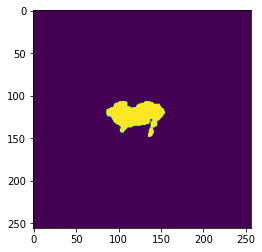

In [6]:
print('Slice from 4D array ')
plt.imshow(mask_4D[:,:,237,0]) #0 pour ROI 1
plt.show()

### CT RTSS to CT array 

In [8]:
mask_builder_rtss = MaskBuilder_RTSS(rtss_path, ct_path)
from time import process_time
t1_start = process_time()
mask_4D = mask_builder_rtss.rtss_to_4D_mask()
t1_stop = process_time() 
print("diff début fin :", t1_stop-t1_start)

diff début fin : 3.0283400489999996


In [9]:
print("Number of ROI in RTSS : ", mask_builder_rtss.number_of_roi)
print("Size of array in CT Modality : ", mask_4D.shape)

Number of ROI in RTSS :  10
Size of array in CT Modality :  (512, 512, 415, 10)


Slice from 4D array 


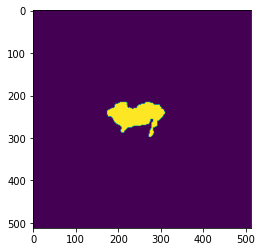

In [17]:
print('Slice from 4D array ')
plt.imshow(mask_4D[:,:,311,0]) #0 pour ROI 1
plt.show()

## Mask -> RTSTRUCT file 


In [ ]:
from library_dicom.rtss_processor.model.RTSS_Writer import RTSS_Writer
import pydicom

In [ ]:
dataset = {}
for i in range(1,11):
    data = {}
    data['ROIName'] = str(i)
    data['ROIGenerationAlgorithm'] = 'SEMIAUTOMATIC'
    dataset[i] = data
print(dataset)    

In [ ]:
new_rtss = RTSS_Writer(mask_4D, ct_path, dataset)

In [ ]:
filename = 'rtss_2.dcm'
directory_path = '/media/deeplearning/78ca2911-9e9f-4f78-b80a-848024b95f92/RT_STRUCT'
new_rtss.save_file(filename, directory_path)